In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
train_df_full = pd.read_csv("/kaggle/input/trains/train.csv")
df = train_df_full.head(2)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   2 non-null      object
 1   output  2 non-null      object
dtypes: object(2)
memory usage: 160.0+ bytes


In [6]:
df

,input,output
0,Cardiovascular disease is the leading cause of...,Medication adherence in cardiovascular medicine.
1,Novel coronavirus disease 2019 (COVID-19) cont...,Consequences of SARS-CoV-2 disease on maternal...


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50
x = df["input"]
y = "sostok " + df["output"] + " eostok"

token = Tokenizer()
token.fit_on_texts(x)
token.fit_on_texts(y)

# Helper Functions
def text_to_token(text):
    return token.texts_to_sequences(text)

def token_to_text(tok):
    return token.sequences_to_texts(tok)

x = text_to_token(x)
y = text_to_token(y)

x = pad_sequences(x,  maxlen=max_len, padding='post')
y = pad_sequences(y,  maxlen=max_len, padding='post')

In [8]:
pip install graphviz


Note: you may need to restart the kernel to use updated packages.


In [13]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.models import Model

latent_dim = 300
embedding_dim = 200

voc = len(token.word_index) + 1

# Encoder
encoder_inputs = Input(shape=(max_len, ))

# Embedding layer
enc_emb = Embedding(voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 50, 200)   │     40,600 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 50, 300), │    601,200 │ embedding_2[0][0] │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 50, 300), │    721,200 │ lstm_4[0][0]      │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 200) │     40,600 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 50, 300), │    721,200 │ lstm_5[0][0]      │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, None,     │    601,200 │ embedding_3[0][0… │
│                     │ 300), (None,      │            │ lstm_6[0][1],     │
│                     │ 300), (None,      │            │ lstm_6[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, None, 203) │     61,103 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,787,103 (10.63 MB)

 Trainable params: 2,787,103 (10.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [8]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
hist = model.fit([x, y[:, :-1]], y[:, 1:], epochs=500, batch_size=32)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 5.3013
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 5.0482
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 4.1848
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 2.1960
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 1.5046
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 1.4337
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 1.4623
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 1.4328
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 1.5345
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 1.3224
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 1.2458
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 1.2568
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 1.3237
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 1.8222
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 1.1686
Epoch

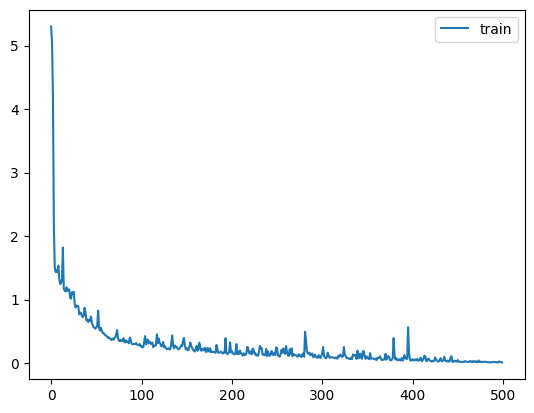

In [9]:
plt.plot(hist.history['loss'], label='train')

plt.legend()
plt.show()

In [62]:
final=hist.history
import pickle
pickle.dump(final, open('modelf.pkl', 'wb'))

In [56]:

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])

In [57]:
reverse_target_word_index = token.index_word
reverse_source_word_index = token.index_word
target_word_index = token.word_index

def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index] if sampled_token_index != 0 else "eostok"

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or sampled_token_index == 0:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [60]:
sent = ["Cardiovascular disease is the leading cause of death globally. While pharmacological advancements have improved the morbidity and mortality associated with cardiovascular disease, non-adherence to prescribed treatment remains a significant barrier to improved patient outcomes. A variety of strategies to improve medication adherence have been tested in clinical trials, and include the following categories: improving patient education, implementing medication reminders, testing cognitive behavioral interventions, reducing medication costs, utilizing healthcare team members, and streamlining medication dosing regimens. In this review, we describe specific trials within each of these categories and highlight the impact of each on medication adherence. We also examine ongoing trials and future lines of inquiry for improving medication adherence in patients with cardiovascular diseases."
        ,"Novel coronavirus disease 2019 (COVID-19) continues to affect pregnant women with concerns for adverse maternal and fetal outcomes and is rapidly spreading throughout many countries since it was first reported in China on 31 December 2019 The aim of this study is to describe characteristics, maternal and fetal outcomes among mothers with confirmed maternal SARS-CoV-2 infection This study presents a retrospective observational cohort study of 62 test-positive cases of coronavirus disease 2019 that presented at an affiliated tertiary university medical city from March 2020 to May 2020 A total of 14 patients (22 5%) presented with obvious typical symptoms of coronavirus disease 2019 associated viremia and were identified after they developed symptoms during admission or after the implementation of universal testing for all obstetric admissions A total of 62 mothers were screened positive for the SARS-CoV-2 infection Length of stay was higher in the symptomatic group The median length of stay was 4 days for the asymptomatic cases while it was 6 days for the symptomatic cases Amniotic fluid was meconium stained in (12 5%) of the asymptomatic group and in 30 8% in the symptomatic group Post discharge mothers with asymptomatic SARS-CoV-2 infection were more likely to breastfeed their infants OR (95% CI) was 1 4 (1 02-1 90) and P-value was 0 0327 There was non-statistically significant absence of perinatal morbidities or mortalities among symptomatic and asymptomatic mothers"
        ]

for s in sent:
    print(summarize(s))

 medication adherence in cardiovascular medicine
 consequences of sars cov disease on maternal perinatal and neonatal outcomes a retrospective observational cohort study


In [61]:
print(summarize("A car filled with Christmas presents was stolen from a home in Melbourne\u2019s north-east on Christmas Day"))


 medication adherence in cardiovascular medicine


In [ ]:
/kaggle/input/summarization/tensorflow2/ewfq/1/Completed_model.joblib

In [17]:
import joblib
Model = joblib.load("/kaggle/input/summarization/tensorflow2/ewfq/1/Completed_model.joblib")